# Phase 4: Preprocessing & Baseline Modeling

**Author**: Nate DeMoro  
**Date**: 2026-01-24  
**Goal**: Prepare feature-engineered dataset for modeling, train baseline models, establish performance benchmarks

## Objectives
1. Encode categorical features
2. Create time-based train/test split (no data leakage)
3. Train Budget-Only baseline (R²≈0.54)
4. Train Full Linear Regression (target R²>0.60)
5. Compare models and analyze errors

## Success Criteria
- Test R² > 0.60 (improvement over budget-only baseline)
- All preprocessing artifacts saved for reproducibility
- Ready for Phase 5 (advanced modeling)

---
## Step 4.1: Setup & Data Loading

In [1]:
# Cell 1: Imports & Environment Setup

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

# Sklearn models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Utilities
import pickle
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Cell 2: Load Feature-Engineered Dataset

# Load data
df = pd.read_csv('../data/processed/movies_features.csv')

# Convert dates
df['release_date'] = pd.to_datetime(df['release_date'])

# Display info
print(f"Dataset: {df.shape[0]:,} movies × {df.shape[1]} columns")
print(f"Date range: {df['release_year'].min()}-{df['release_year'].max()}")
print(f"\nColumns:\n{list(df.columns)}")

# Check data types
print(f"\nData Types:")
print(df.dtypes)

Dataset: 2,095 movies × 36 columns
Date range: 2010-2024

Columns:
['tmdb_id', 'imdb_id', 'title', 'release_date', 'budget', 'runtime', 'num_genres', 'num_production_companies', 'primary_genre', 'us_certification', 'is_english', 'release_month', 'release_year', 'release_quarter', 'is_summer_release', 'is_holiday_release', 'release_day_of_week', 'is_weekend_release', 'director_historical_avg', 'is_first_time_director', 'director_film_count', 'lead_actor_historical_avg', 'is_first_time_lead', 'num_a_list_actors', 'num_releases_same_weekend', 'num_releases_same_month', 'budget_category', 'runtime_category', 'is_multi_genre', 'is_sequel', 'director_genre_match', 'release_month_avg_revenue', 'revenue_worldwide', 'profit', 'roi_pct', 'is_profitable']

Data Types:
tmdb_id                               int64
imdb_id                              object
title                                object
release_date                 datetime64[ns]
budget                              float64
runtime     

TARGET VARIABLE: revenue_worldwide
count         2095.00
mean     151357257.32
std      264431765.67
min           1281.00
25%        5217537.50
50%       45640143.00
75%      174813366.00
max     2799439100.00
Name: revenue_worldwide, dtype: float64

Missing Values:
                  Missing_Count  Missing_Pct
us_certification            484        23.10
runtime_category              1         0.05
imdb_id                       1         0.05


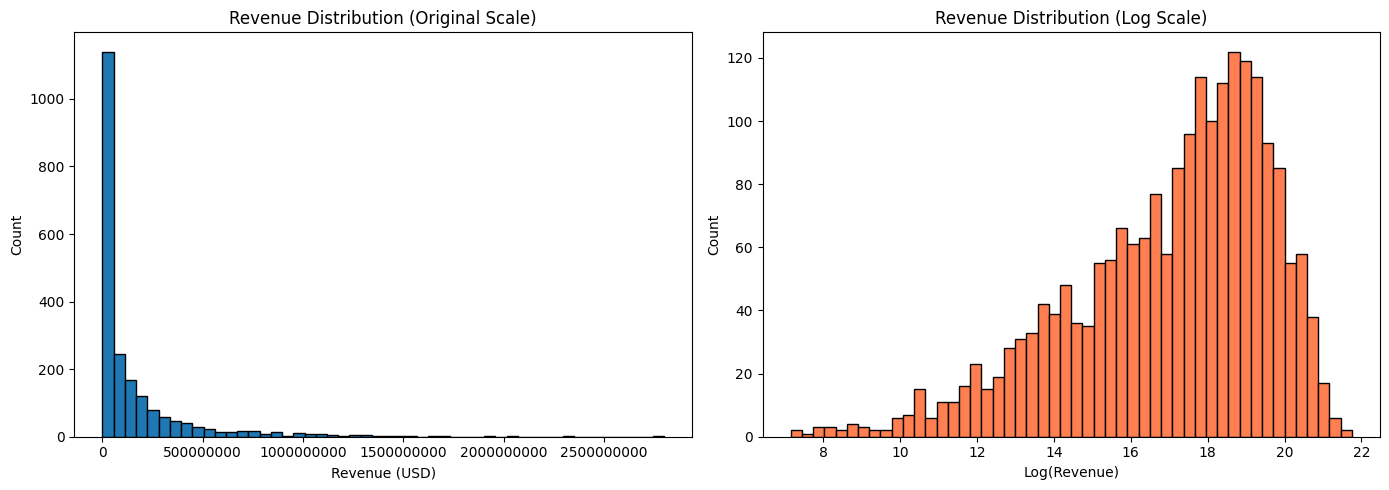


Skewness (original): 3.40
Skewness (log): -0.88


In [3]:
# Cell 3: Initial Data Exploration

# Summary statistics
print("TARGET VARIABLE: revenue_worldwide")
print(df['revenue_worldwide'].describe())

# Missing values check
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Pct': missing_pct
}).sort_values('Missing_Count', ascending=False)

print("\nMissing Values:")
print(missing_df[missing_df['Missing_Count'] > 0])

# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['revenue_worldwide'], bins=50, edgecolor='black')
axes[0].set_xlabel('Revenue (USD)')
axes[0].set_ylabel('Count')
axes[0].set_title('Revenue Distribution (Original Scale)')
axes[0].ticklabel_format(style='plain', axis='x')

axes[1].hist(np.log(df['revenue_worldwide']), bins=50, edgecolor='black', color='coral')
axes[1].set_xlabel('Log(Revenue)')
axes[1].set_ylabel('Count')
axes[1].set_title('Revenue Distribution (Log Scale)')

plt.tight_layout()
plt.savefig('../visualizations/revenue_distribution_preprocessing.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSkewness (original): {df['revenue_worldwide'].skew():.2f}")
print(f"Skewness (log): {np.log(df['revenue_worldwide']).skew():.2f}")

---
## Step 4.2: Feature Selection & Categorical Encoding

In [4]:
# Cell 1: Define Feature Sets

# Define feature groups
METADATA_COLS = ['tmdb_id', 'imdb_id', 'title', 'release_date']
TARGET = 'revenue_worldwide'
OUTCOME_COLS = ['profit', 'roi_pct', 'is_profitable']

# Numeric features (ready to use)
NUMERIC_FEATURES = [
    'budget', 'runtime', 'num_genres', 'num_production_companies',
    'release_month', 'release_year', 'release_quarter',
    'is_summer_release', 'is_holiday_release', 'release_day_of_week',
    'is_weekend_release', 'is_english',
    'director_historical_avg', 'is_first_time_director', 'director_film_count',
    'lead_actor_historical_avg', 'is_first_time_lead', 'num_a_list_actors',
    'num_releases_same_weekend', 'num_releases_same_month',
    'release_month_avg_revenue', 'is_multi_genre', 'is_sequel',
    'director_genre_match'
]

# Categorical features (need encoding)
CATEGORICAL_FEATURES = [
    'primary_genre',       # 752 unique values
    'us_certification',    # 6 values (23% missing)
    'budget_category',     # 5 values (ordinal)
    'runtime_category'     # 4 values (ordinal)
]

print(f"Total features: {len(NUMERIC_FEATURES) + len(CATEGORICAL_FEATURES)}")
print(f"  Numeric: {len(NUMERIC_FEATURES)}")
print(f"  Categorical: {len(CATEGORICAL_FEATURES)}")

Total features: 28
  Numeric: 24
  Categorical: 4


In [5]:
# Cell 2: Handle primary_genre (Multi-Value Field)

# Extract first genre only
df['genre_primary_single'] = df['primary_genre'].str.split('|').str[0]

print(f"Unique primary genres (first only): {df['genre_primary_single'].nunique()}")
print("\nTop 10 genres:")
print(df['genre_primary_single'].value_counts().head(10))

# Create binary flags for top 10 genres (one-hot encoding alternative)
top_genres = df['genre_primary_single'].value_counts().head(10).index.tolist()
for genre in top_genres:
    df[f'is_{genre.lower().replace(" ", "_")}'] = (df['genre_primary_single'] == genre).astype(int)

print(f"\nCreated {len(top_genres)} genre binary flags")

# Decision: Use genre_primary_single for encoding
print("\nUsing genre_primary_single for categorical encoding")

Unique primary genres (first only): 18

Top 10 genres:
genre_primary_single
Action             456
Drama              413
Comedy             280
Horror             175
Animation          120
Adventure          108
Thriller           103
Science Fiction     83
Crime               82
Fantasy             62
Name: count, dtype: int64

Created 10 genre binary flags

Using genre_primary_single for categorical encoding


In [6]:
# Cell 3: Handle Missing Values

# us_certification: 484 missing (23.1%)
# Strategy: Create 'Unknown' category
df['us_certification'].fillna('Unknown', inplace=True)
print(f"us_certification missing handled: {df['us_certification'].isna().sum()} remaining")

# runtime_category: 1 missing
# Strategy: Fill with mode
mode_runtime = df['runtime_category'].mode()[0]
df['runtime_category'].fillna(mode_runtime, inplace=True)
print(f"runtime_category missing handled: {df['runtime_category'].isna().sum()} remaining")

# Verify no missing in features
feature_cols = NUMERIC_FEATURES + CATEGORICAL_FEATURES
missing_check = df[feature_cols].isnull().sum().sum()
print(f"\nTotal missing values in features: {missing_check}")

us_certification missing handled: 0 remaining
runtime_category missing handled: 0 remaining

Total missing values in features: 0


In [7]:
# Cell 4: Encode Categorical Features

# Create copy for encoding
df_encoded = df.copy()

# 1. Ordinal encoding for ordinal categories
# us_certification: G < PG < PG-13 < R < NC-17 < Unknown
cert_order = ['G', 'PG', 'PG-13', 'R', 'NC-17', 'Unknown']
cert_encoder = OrdinalEncoder(categories=[cert_order], handle_unknown='use_encoded_value', unknown_value=-1)
df_encoded['us_certification_encoded'] = cert_encoder.fit_transform(df_encoded[['us_certification']])

# budget_category: Micro < Low < Medium < High < Blockbuster
budget_order = ['Micro', 'Low', 'Medium', 'High', 'Blockbuster']
budget_encoder = OrdinalEncoder(categories=[budget_order])
df_encoded['budget_category_encoded'] = budget_encoder.fit_transform(df_encoded[['budget_category']])

# runtime_category: Short < Standard < Long < Epic
runtime_order = ['Short', 'Standard', 'Long', 'Epic']
runtime_encoder = OrdinalEncoder(categories=[runtime_order])
df_encoded['runtime_category_encoded'] = runtime_encoder.fit_transform(df_encoded[['runtime_category']])

# 2. Label encoding for genre (nominal)
genre_encoder = LabelEncoder()
df_encoded['genre_primary_encoded'] = genre_encoder.fit_transform(df_encoded['genre_primary_single'])

print("✓ Categorical features encoded:")
print(f"  us_certification: {len(cert_order)} categories → 0-{len(cert_order)-1}")
print(f"  budget_category: {len(budget_order)} categories → 0-{len(budget_order)-1}")
print(f"  runtime_category: {len(runtime_order)} categories → 0-{len(runtime_order)-1}")
print(f"  genre_primary: {df_encoded['genre_primary_encoded'].nunique()} unique genres → 0-{df_encoded['genre_primary_encoded'].max()}")

# Save encoders for future use
encoders = {
    'us_certification': cert_encoder,
    'budget_category': budget_encoder,
    'runtime_category': runtime_encoder,
    'genre_primary': genre_encoder
}

with open('../models/feature_encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

print("\n✓ Encoders saved to models/feature_encoders.pkl")

✓ Categorical features encoded:
  us_certification: 6 categories → 0-5
  budget_category: 5 categories → 0-4
  runtime_category: 4 categories → 0-3
  genre_primary: 18 unique genres → 0-17

✓ Encoders saved to models/feature_encoders.pkl


In [8]:
# Cell 5: Create Final Feature List

# Updated numeric features (include encoded categoricals)
ENCODED_FEATURES = [
    'us_certification_encoded',
    'budget_category_encoded',
    'runtime_category_encoded',
    'genre_primary_encoded'
]

ALL_FEATURES = NUMERIC_FEATURES + ENCODED_FEATURES

print(f"Total features for modeling: {len(ALL_FEATURES)}")
print(f"\nFeature list:\n{ALL_FEATURES}")

# Create modeling dataframe
X = df_encoded[ALL_FEATURES].copy()
y = df_encoded[TARGET].copy()

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nMissing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {y.isnull().sum()}")

Total features for modeling: 28

Feature list:
['budget', 'runtime', 'num_genres', 'num_production_companies', 'release_month', 'release_year', 'release_quarter', 'is_summer_release', 'is_holiday_release', 'release_day_of_week', 'is_weekend_release', 'is_english', 'director_historical_avg', 'is_first_time_director', 'director_film_count', 'lead_actor_historical_avg', 'is_first_time_lead', 'num_a_list_actors', 'num_releases_same_weekend', 'num_releases_same_month', 'release_month_avg_revenue', 'is_multi_genre', 'is_sequel', 'director_genre_match', 'us_certification_encoded', 'budget_category_encoded', 'runtime_category_encoded', 'genre_primary_encoded']

X shape: (2095, 28)
y shape: (2095,)

Missing values in X: 0
Missing values in y: 0


---
## Step 4.3: Train/Test Split

In [9]:
# Cell 1: Time-Based Split

# Define split point
TRAIN_END_YEAR = 2021
TEST_START_YEAR = 2022

# Create split masks
train_mask = df_encoded['release_year'] <= TRAIN_END_YEAR
test_mask = df_encoded['release_year'] >= TEST_START_YEAR

# Split data
X_train = X[train_mask].copy()
X_test = X[test_mask].copy()
y_train = y[train_mask].copy()
y_test = y[test_mask].copy()

# Also keep metadata for analysis
train_metadata = df_encoded.loc[train_mask, METADATA_COLS + ['release_year']].copy()
test_metadata = df_encoded.loc[test_mask, METADATA_COLS + ['release_year']].copy()

print("TRAIN/TEST SPLIT (Time-Based)")
print("=" * 60)
print(f"Training Set:")
print(f"  Years: 2010-{TRAIN_END_YEAR}")
print(f"  Size: {len(X_train):,} movies ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Revenue - Mean: ${y_train.mean():,.0f}, Median: ${y_train.median():,.0f}")
print(f"\nTest Set:")
print(f"  Years: {TEST_START_YEAR}-2024")
print(f"  Size: {len(X_test):,} movies ({len(X_test)/len(X)*100:.1f}%)")
print(f"  Revenue - Mean: ${y_test.mean():,.0f}, Median: ${y_test.median():,.0f}")

# Verify no overlap
train_years = set(df_encoded.loc[train_mask, 'release_year'])
test_years = set(df_encoded.loc[test_mask, 'release_year'])
overlap = train_years.intersection(test_years)
print(f"\n✓ No year overlap: {len(overlap) == 0}")

TRAIN/TEST SPLIT (Time-Based)
Training Set:
  Years: 2010-2021
  Size: 1,682 movies (80.3%)
  Revenue - Mean: $155,684,952, Median: $49,671,219

Test Set:
  Years: 2022-2024
  Size: 413 movies (19.7%)
  Revenue - Mean: $133,732,117, Median: $29,116,320

✓ No year overlap: True


In [10]:
# Cell 2: Feature Scaling

# StandardScaler (mean=0, std=1)
scaler = StandardScaler()

# Fit on training data only (critical: don't leak test statistics!)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use training stats

# Convert back to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Features scaled (StandardScaler)")
print(f"\nTraining set stats (after scaling):")
print(f"  Mean: {X_train_scaled.mean().mean():.4f} (should be ~0)")
print(f"  Std: {X_train_scaled.std().mean():.4f} (should be ~1)")

# Save scaler
with open('../models/feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✓ Scaler saved to models/feature_scaler.pkl")

# Also create unscaled versions for tree-based models (Phase 5)
print("\n✓ Unscaled train/test sets retained for Random Forest/XGBoost (Phase 5)")

✓ Features scaled (StandardScaler)

Training set stats (after scaling):
  Mean: 0.0000 (should be ~0)
  Std: 1.0003 (should be ~1)
✓ Scaler saved to models/feature_scaler.pkl

✓ Unscaled train/test sets retained for Random Forest/XGBoost (Phase 5)


---
## Step 4.4: Baseline Model 1 - Budget Only

In [11]:
# Cell 1: Train Budget-Only Model

print("=" * 60)
print("BASELINE MODEL 1: Linear Regression (Budget Only)")
print("=" * 60)

# Create budget-only datasets
X_train_budget = X_train_scaled[['budget']].copy()
X_test_budget = X_test_scaled[['budget']].copy()

# Train model
model_budget = LinearRegression()
model_budget.fit(X_train_budget, y_train)

# Predictions
y_train_pred_budget = model_budget.predict(X_train_budget)
y_test_pred_budget = model_budget.predict(X_test_budget)

# Evaluate
train_r2_budget = r2_score(y_train, y_train_pred_budget)
test_r2_budget = r2_score(y_test, y_test_pred_budget)
train_mae_budget = mean_absolute_error(y_train, y_train_pred_budget)
test_mae_budget = mean_absolute_error(y_test, y_test_pred_budget)
train_rmse_budget = np.sqrt(mean_squared_error(y_train, y_train_pred_budget))
test_rmse_budget = np.sqrt(mean_squared_error(y_test, y_test_pred_budget))

print(f"\nTRAINING SET PERFORMANCE:")
print(f"  R²: {train_r2_budget:.4f}")
print(f"  MAE: ${train_mae_budget:,.0f}")
print(f"  RMSE: ${train_rmse_budget:,.0f}")

print(f"\nTEST SET PERFORMANCE:")
print(f"  R²: {test_r2_budget:.4f}")
print(f"  MAE: ${test_mae_budget:,.0f}")
print(f"  RMSE: ${test_rmse_budget:,.0f}")

print(f"\nModel Coefficient (Budget): {model_budget.coef_[0]:.4f}")
print(f"Model Intercept: {model_budget.intercept_:,.0f}")

# Save model
with open('../models/baseline_budget_only.pkl', 'wb') as f:
    pickle.dump(model_budget, f)

print("\n✓ Model saved to models/baseline_budget_only.pkl")

BASELINE MODEL 1: Linear Regression (Budget Only)

TRAINING SET PERFORMANCE:
  R²: 0.5861
  MAE: $89,809,670
  RMSE: $169,573,221

TEST SET PERFORMANCE:
  R²: 0.4016
  MAE: $110,058,535
  RMSE: $206,403,252

Model Coefficient (Budget): 201793319.8291
Model Intercept: 155,684,952

✓ Model saved to models/baseline_budget_only.pkl


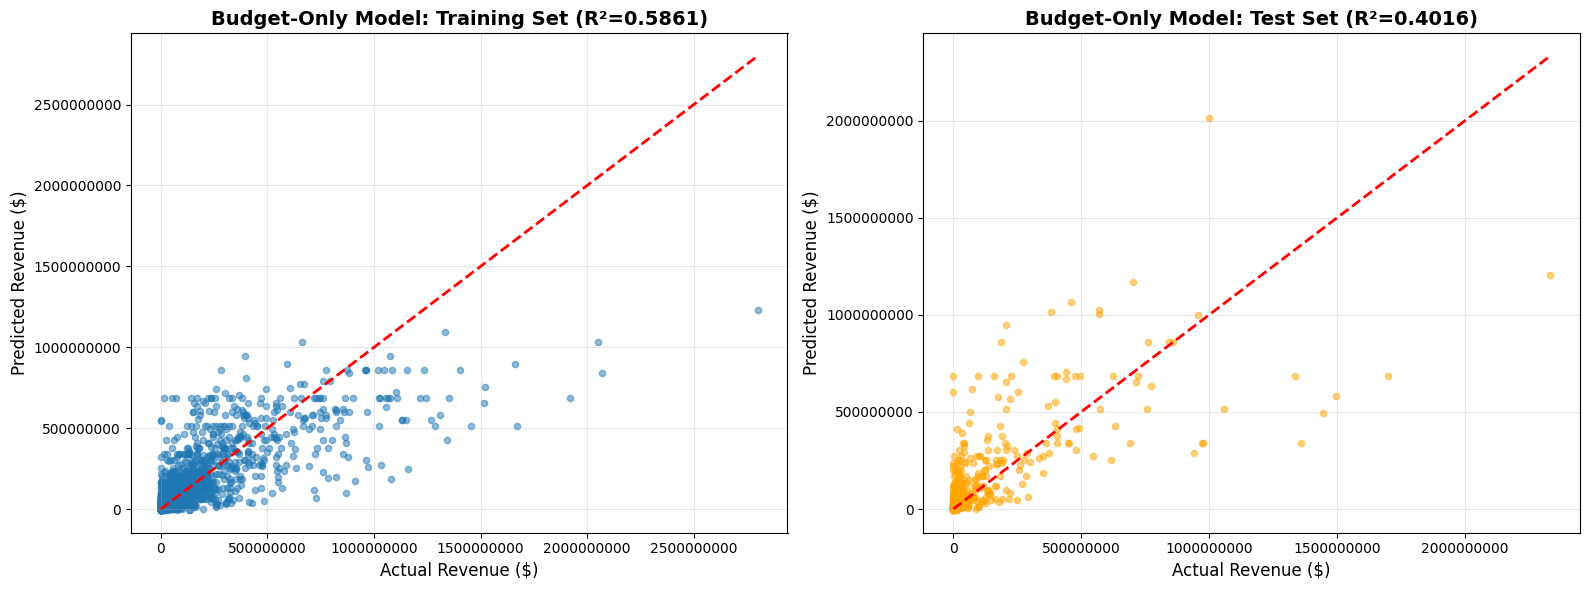

In [12]:
# Cell 2: Visualize Budget-Only Model

# Actual vs Predicted plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_train_pred_budget, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Revenue ($)', fontsize=12)
axes[0].set_ylabel('Predicted Revenue ($)', fontsize=12)
axes[0].set_title(f'Budget-Only Model: Training Set (R²={train_r2_budget:.4f})', fontsize=14, fontweight='bold')
axes[0].ticklabel_format(style='plain', axis='both')
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_budget, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Revenue ($)', fontsize=12)
axes[1].set_ylabel('Predicted Revenue ($)', fontsize=12)
axes[1].set_title(f'Budget-Only Model: Test Set (R²={test_r2_budget:.4f})', fontsize=14, fontweight='bold')
axes[1].ticklabel_format(style='plain', axis='both')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/baseline_budget_only_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

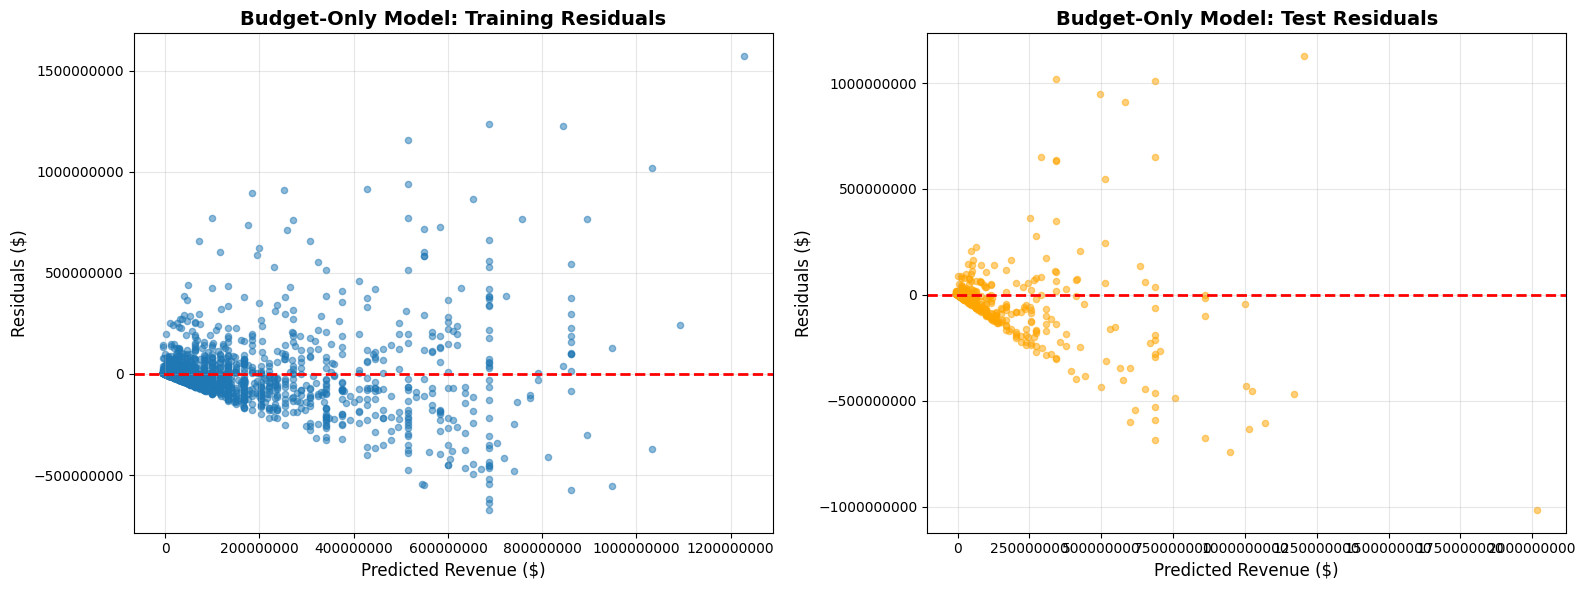

Budget-Only Baseline: Visualization complete


In [13]:
# Cell 3: Residual Analysis

# Residuals
train_residuals_budget = y_train - y_train_pred_budget
test_residuals_budget = y_test - y_test_pred_budget

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training residuals
axes[0].scatter(y_train_pred_budget, train_residuals_budget, alpha=0.5, s=20)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Revenue ($)', fontsize=12)
axes[0].set_ylabel('Residuals ($)', fontsize=12)
axes[0].set_title('Budget-Only Model: Training Residuals', fontsize=14, fontweight='bold')
axes[0].ticklabel_format(style='plain', axis='both')
axes[0].grid(alpha=0.3)

# Test residuals
axes[1].scatter(y_test_pred_budget, test_residuals_budget, alpha=0.5, s=20, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Revenue ($)', fontsize=12)
axes[1].set_ylabel('Residuals ($)', fontsize=12)
axes[1].set_title('Budget-Only Model: Test Residuals', fontsize=14, fontweight='bold')
axes[1].ticklabel_format(style='plain', axis='both')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/baseline_budget_only_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

print("Budget-Only Baseline: Visualization complete")

---
## Step 4.5: Baseline Model 2 - Full Linear Regression

In [14]:
# Cell 1: Train Full Linear Regression

print("=" * 60)
print("BASELINE MODEL 2: Linear Regression (All 28 Features)")
print("=" * 60)

# Train model
model_full = LinearRegression()
model_full.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_full = model_full.predict(X_train_scaled)
y_test_pred_full = model_full.predict(X_test_scaled)

# Evaluate
train_r2_full = r2_score(y_train, y_train_pred_full)
test_r2_full = r2_score(y_test, y_test_pred_full)
train_mae_full = mean_absolute_error(y_train, y_train_pred_full)
test_mae_full = mean_absolute_error(y_test, y_test_pred_full)
train_rmse_full = np.sqrt(mean_squared_error(y_train, y_train_pred_full))
test_rmse_full = np.sqrt(mean_squared_error(y_test, y_test_pred_full))

print(f"\nTRAINING SET PERFORMANCE:")
print(f"  R²: {train_r2_full:.4f}")
print(f"  MAE: ${train_mae_full:,.0f}")
print(f"  RMSE: ${train_rmse_full:,.0f}")

print(f"\nTEST SET PERFORMANCE:")
print(f"  R²: {test_r2_full:.4f}")
print(f"  MAE: ${test_mae_full:,.0f}")
print(f"  RMSE: ${test_rmse_full:,.0f}")

# Check for overfitting
overfit_gap = train_r2_full - test_r2_full
print(f"\nOverfitting Check:")
print(f"  Train R² - Test R²: {overfit_gap:.4f}")
if overfit_gap > 0.10:
    print("  ⚠ Significant overfitting detected (>0.10 gap)")
elif overfit_gap > 0.05:
    print("  ⚠ Moderate overfitting (0.05-0.10 gap)")
else:
    print("  ✓ Minimal overfitting (<0.05 gap)")

# Save model
with open('../models/baseline_linear_regression_full.pkl', 'wb') as f:
    pickle.dump(model_full, f)

print("\n✓ Model saved to models/baseline_linear_regression_full.pkl")

BASELINE MODEL 2: Linear Regression (All 28 Features)

TRAINING SET PERFORMANCE:
  R²: 0.7092
  MAE: $78,063,412
  RMSE: $142,128,316

TEST SET PERFORMANCE:
  R²: 0.5086
  MAE: $94,877,285
  RMSE: $187,049,424

Overfitting Check:
  Train R² - Test R²: 0.2007
  ⚠ Significant overfitting detected (>0.10 gap)

✓ Model saved to models/baseline_linear_regression_full.pkl



TOP 10 FEATURES (by absolute coefficient):
                  Feature  Coefficient
                   budget 150203735.02
  director_historical_avg  96407251.53
  budget_category_encoded -44149517.48
lead_actor_historical_avg  33780999.52
                is_sequel  13189021.14
      director_film_count -11016726.46
                  runtime  11005398.59
      release_day_of_week  -9751440.73
               num_genres  -9296389.30
 num_production_companies  -8757581.75

BOTTOM 10 FEATURES (by absolute coefficient):
                  Feature  Coefficient
  num_releases_same_month  -2946068.04
num_releases_same_weekend  -2868131.93
       is_first_time_lead  -2680456.10
     director_genre_match   1987201.73
               is_english  -1943025.96
           is_multi_genre   1579301.87
        is_summer_release  -1389134.92
 runtime_category_encoded   1275938.46
          release_quarter   1058308.31
    genre_primary_encoded   -983696.09


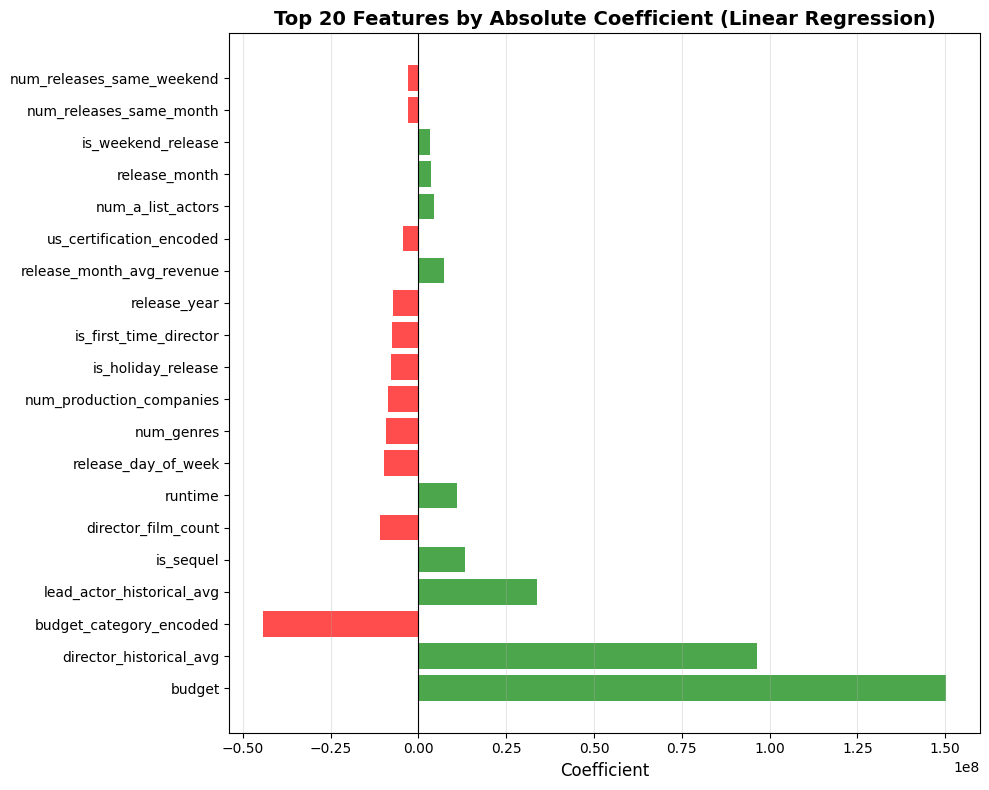


✓ Coefficients saved to data/processed/linear_regression_coefficients.csv


In [15]:
# Cell 2: Feature Importance (Coefficients)

# Get feature importance from coefficients
coefficients = pd.DataFrame({
    'Feature': ALL_FEATURES,
    'Coefficient': model_full.coef_
}).sort_values('Coefficient', ascending=False, key=abs)

print("\nTOP 10 FEATURES (by absolute coefficient):")
print(coefficients.head(10).to_string(index=False))

print("\nBOTTOM 10 FEATURES (by absolute coefficient):")
print(coefficients.tail(10).to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
top_20 = coefficients.head(20)
colors = ['green' if x > 0 else 'red' for x in top_20['Coefficient']]
ax.barh(top_20['Feature'], top_20['Coefficient'], color=colors, alpha=0.7)
ax.set_xlabel('Coefficient', fontsize=12)
ax.set_title('Top 20 Features by Absolute Coefficient (Linear Regression)', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', lw=0.8)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/linear_regression_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

# Save coefficients
coefficients.to_csv('../data/processed/linear_regression_coefficients.csv', index=False)
print("\n✓ Coefficients saved to data/processed/linear_regression_coefficients.csv")

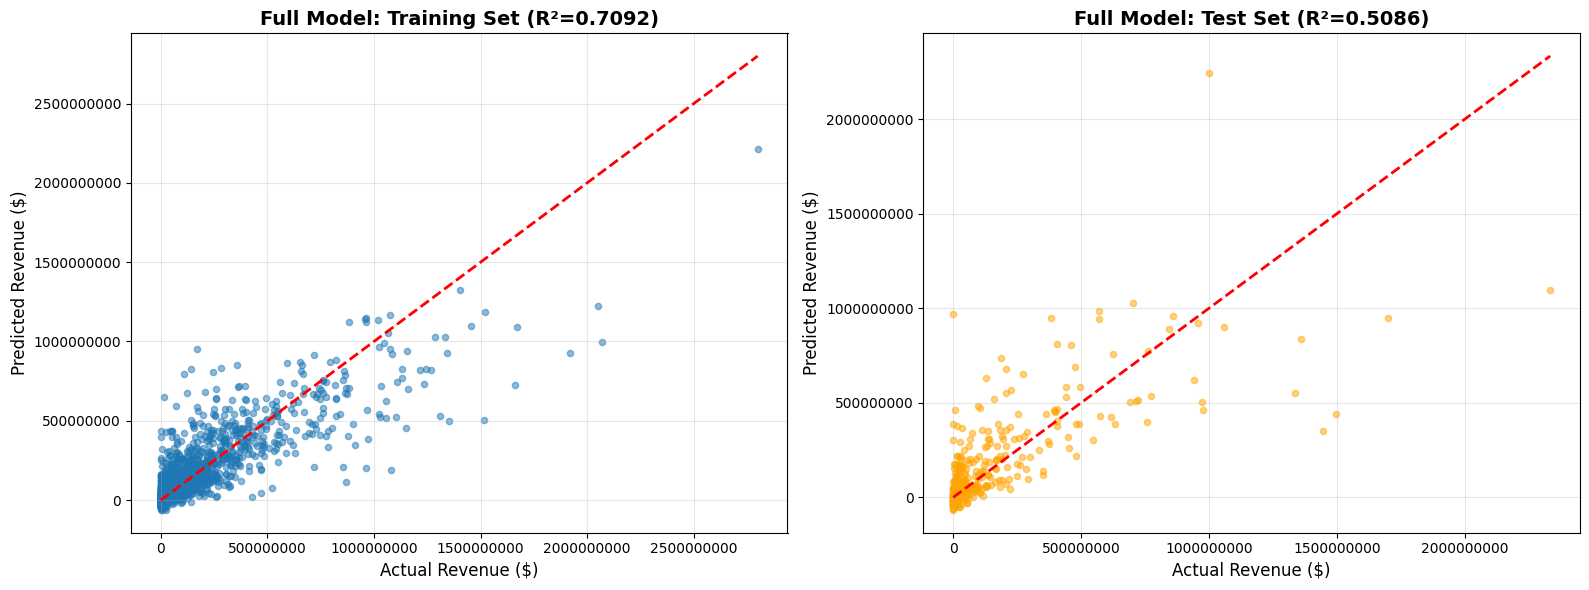

In [16]:
# Cell 3: Visualize Full Model Performance

# Actual vs Predicted plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_train_pred_full, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Revenue ($)', fontsize=12)
axes[0].set_ylabel('Predicted Revenue ($)', fontsize=12)
axes[0].set_title(f'Full Model: Training Set (R²={train_r2_full:.4f})', fontsize=14, fontweight='bold')
axes[0].ticklabel_format(style='plain', axis='both')
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_full, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Revenue ($)', fontsize=12)
axes[1].set_ylabel('Predicted Revenue ($)', fontsize=12)
axes[1].set_title(f'Full Model: Test Set (R²={test_r2_full:.4f})', fontsize=14, fontweight='bold')
axes[1].ticklabel_format(style='plain', axis='both')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/baseline_full_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

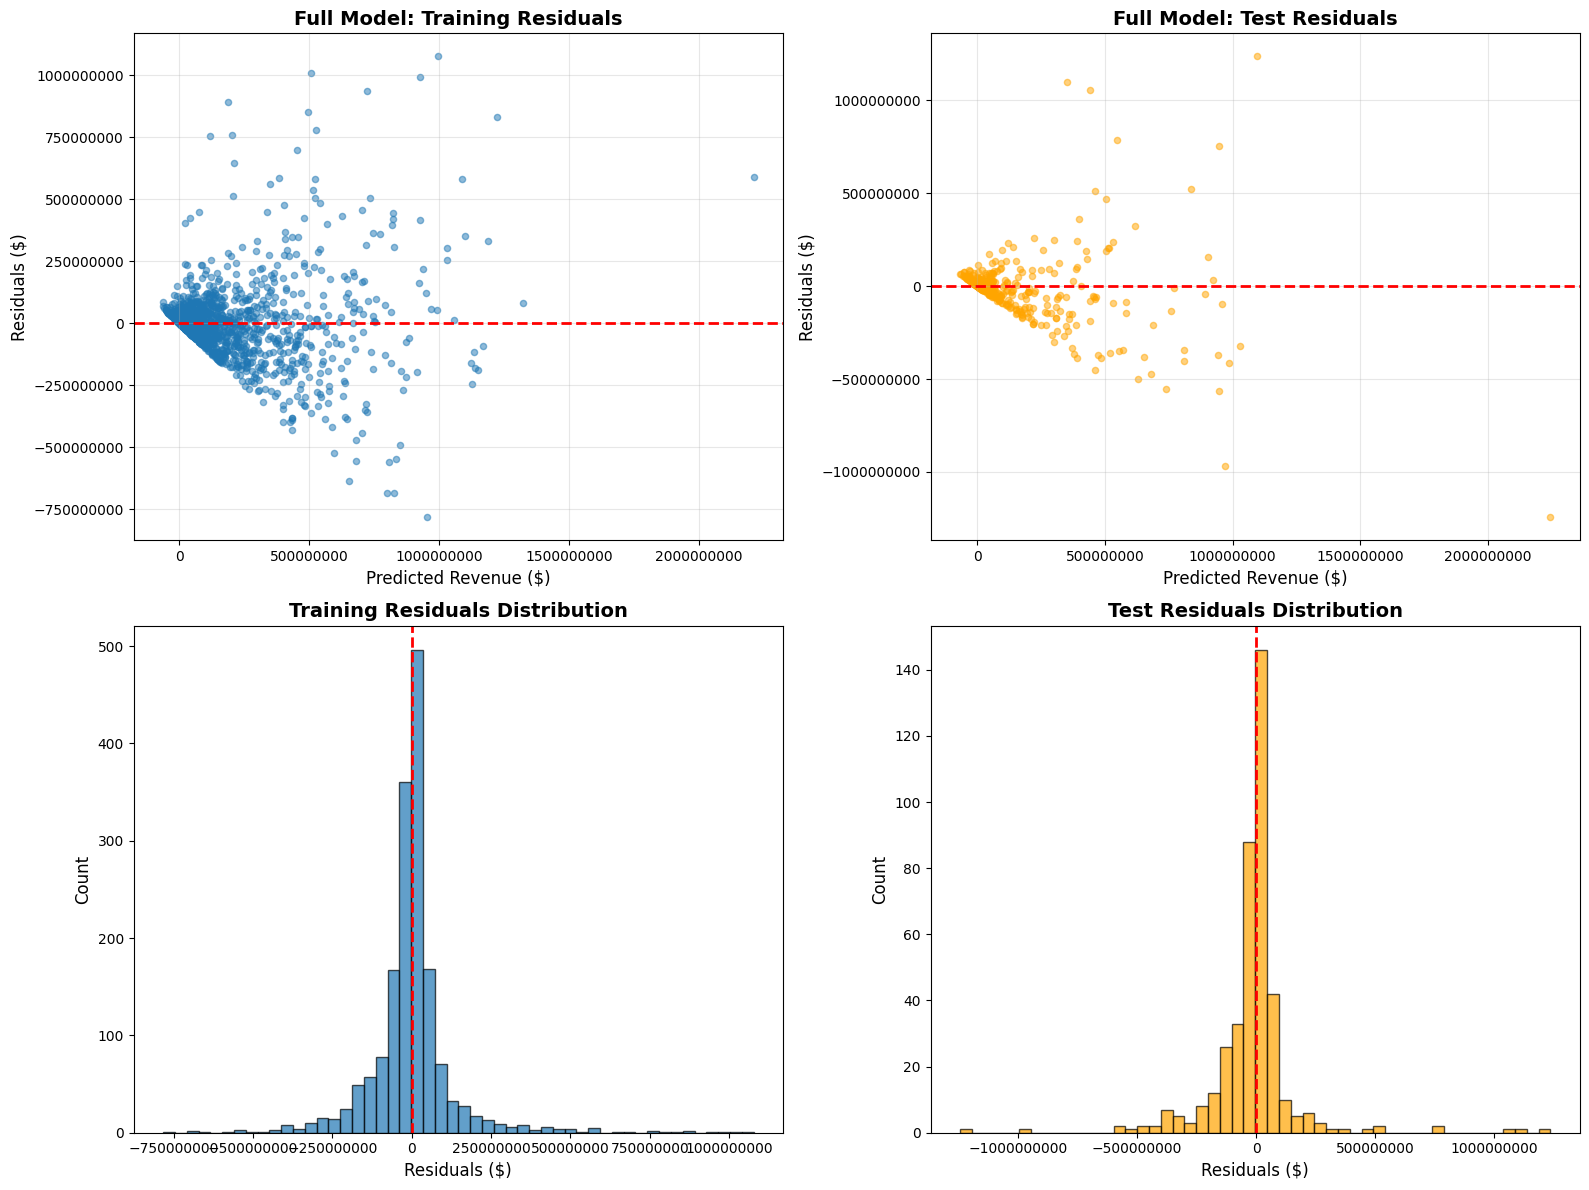

Full Model: Visualization complete


In [17]:
# Cell 4: Residual Analysis (Full Model)

# Residuals
train_residuals_full = y_train - y_train_pred_full
test_residuals_full = y_test - y_test_pred_full

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Training: Residuals vs Predicted
axes[0, 0].scatter(y_train_pred_full, train_residuals_full, alpha=0.5, s=20)
axes[0, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Predicted Revenue ($)', fontsize=12)
axes[0, 0].set_ylabel('Residuals ($)', fontsize=12)
axes[0, 0].set_title('Full Model: Training Residuals', fontsize=14, fontweight='bold')
axes[0, 0].ticklabel_format(style='plain', axis='both')
axes[0, 0].grid(alpha=0.3)

# Test: Residuals vs Predicted
axes[0, 1].scatter(y_test_pred_full, test_residuals_full, alpha=0.5, s=20, color='orange')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Revenue ($)', fontsize=12)
axes[0, 1].set_ylabel('Residuals ($)', fontsize=12)
axes[0, 1].set_title('Full Model: Test Residuals', fontsize=14, fontweight='bold')
axes[0, 1].ticklabel_format(style='plain', axis='both')
axes[0, 1].grid(alpha=0.3)

# Training: Residual histogram
axes[1, 0].hist(train_residuals_full, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals ($)', fontsize=12)
axes[1, 0].set_ylabel('Count', fontsize=12)
axes[1, 0].set_title('Training Residuals Distribution', fontsize=14, fontweight='bold')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].ticklabel_format(style='plain', axis='x')

# Test: Residual histogram
axes[1, 1].hist(test_residuals_full, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_xlabel('Residuals ($)', fontsize=12)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].set_title('Test Residuals Distribution', fontsize=14, fontweight='bold')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.savefig('../visualizations/baseline_full_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

print("Full Model: Visualization complete")

---
## Step 4.6: Model Comparison & Analysis

In [18]:
# Cell 1: Compare Baseline Models

print("=" * 60)
print("BASELINE MODEL COMPARISON")
print("=" * 60)

# Create comparison table
comparison = pd.DataFrame({
    'Model': ['Budget Only', 'Full Linear Regression'],
    'Features': [1, len(ALL_FEATURES)],
    'Train_R2': [train_r2_budget, train_r2_full],
    'Test_R2': [test_r2_budget, test_r2_full],
    'Train_MAE': [train_mae_budget, train_mae_full],
    'Test_MAE': [test_mae_budget, test_mae_full],
    'Train_RMSE': [train_rmse_budget, train_rmse_full],
    'Test_RMSE': [test_rmse_budget, test_rmse_full],
    'Overfitting_Gap': [
        train_r2_budget - test_r2_budget,
        train_r2_full - test_r2_full
    ]
})

print("\nPerformance Summary:")
print(comparison.to_string(index=False))

# Calculate improvement
r2_improvement = test_r2_full - test_r2_budget
mae_improvement = test_mae_budget - test_mae_full
pct_improvement = (r2_improvement / test_r2_budget) * 100

print(f"\n✓ IMPROVEMENT FROM FEATURE ENGINEERING:")
print(f"  R² Gain: {r2_improvement:.4f} ({pct_improvement:.1f}% relative improvement)")
print(f"  MAE Reduction: ${mae_improvement:,.0f}")

# Check if targets met
print(f"\n✓ TARGET ACHIEVEMENT CHECK:")
print(f"  Test R² > 0.60: {'✓ PASS' if test_r2_full > 0.60 else '✗ FAIL'} (Actual: {test_r2_full:.4f})")
print(f"  Test MAE < $50M: {'✓ PASS' if test_mae_full < 50e6 else '✗ FAIL'} (Actual: ${test_mae_full:,.0f})")

# Save comparison
comparison.to_csv('../data/processed/baseline_model_comparison.csv', index=False)
print("\n✓ Comparison saved to data/processed/baseline_model_comparison.csv")

BASELINE MODEL COMPARISON

Performance Summary:
                 Model  Features  Train_R2  Test_R2   Train_MAE     Test_MAE   Train_RMSE    Test_RMSE  Overfitting_Gap
           Budget Only         1      0.59     0.40 89809669.85 110058535.40 169573220.65 206403251.57             0.18
Full Linear Regression        28      0.71     0.51 78063411.69  94877284.77 142128315.88 187049423.87             0.20

✓ IMPROVEMENT FROM FEATURE ENGINEERING:
  R² Gain: 0.1070 (26.6% relative improvement)
  MAE Reduction: $15,181,251

✓ TARGET ACHIEVEMENT CHECK:
  Test R² > 0.60: ✗ FAIL (Actual: 0.5086)
  Test MAE < $50M: ✗ FAIL (Actual: $94,877,285)

✓ Comparison saved to data/processed/baseline_model_comparison.csv


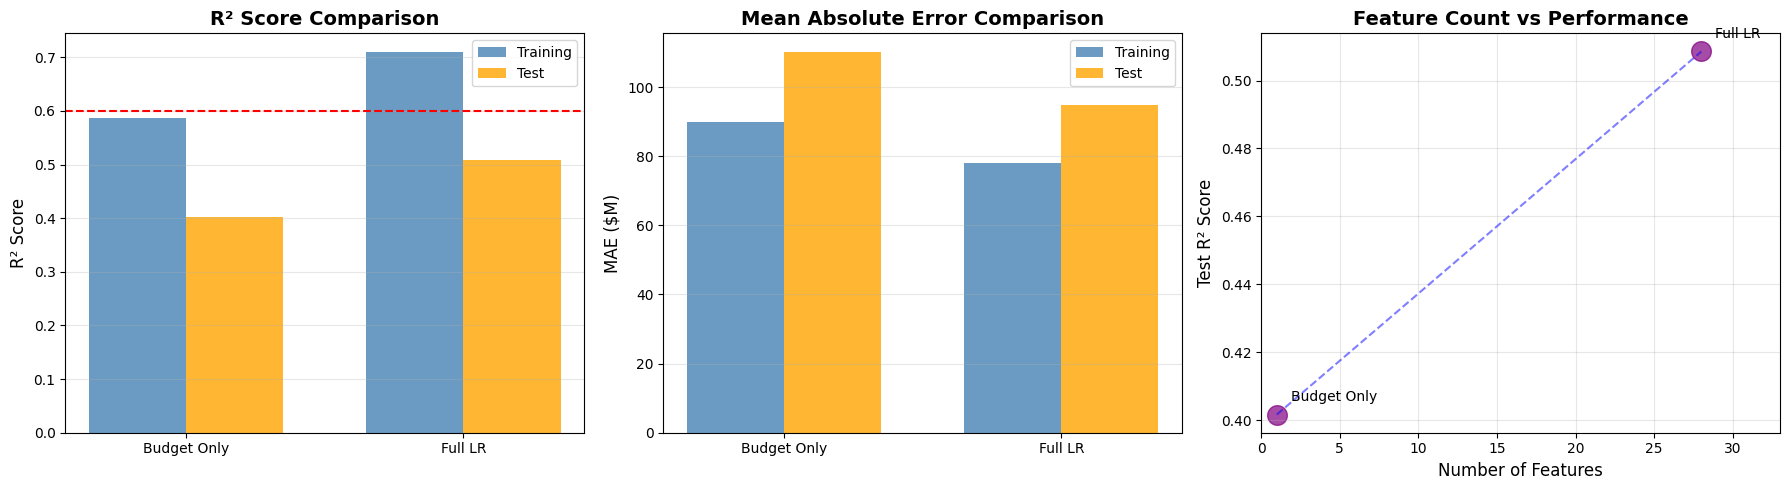

In [19]:
# Cell 2: Visualize Model Comparison

# Create comparison visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² comparison
models = ['Budget Only', 'Full LR']
train_r2s = [train_r2_budget, train_r2_full]
test_r2s = [test_r2_budget, test_r2_full]

x_pos = np.arange(len(models))
width = 0.35

axes[0].bar(x_pos - width/2, train_r2s, width, label='Training', color='steelblue', alpha=0.8)
axes[0].bar(x_pos + width/2, test_r2s, width, label='Test', color='orange', alpha=0.8)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].axhline(y=0.60, color='red', linestyle='--', label='Target (0.60)')
axes[0].grid(axis='y', alpha=0.3)

# MAE comparison
train_maes = [train_mae_budget / 1e6, train_mae_full / 1e6]  # Convert to millions
test_maes = [test_mae_budget / 1e6, test_mae_full / 1e6]

axes[1].bar(x_pos - width/2, train_maes, width, label='Training', color='steelblue', alpha=0.8)
axes[1].bar(x_pos + width/2, test_maes, width, label='Test', color='orange', alpha=0.8)
axes[1].set_ylabel('MAE ($M)', fontsize=12)
axes[1].set_title('Mean Absolute Error Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Feature count vs R²
feature_counts = [1, len(ALL_FEATURES)]
axes[2].scatter(feature_counts, test_r2s, s=200, alpha=0.7, color='purple')
axes[2].plot(feature_counts, test_r2s, 'b--', alpha=0.5)
axes[2].set_xlabel('Number of Features', fontsize=12)
axes[2].set_ylabel('Test R² Score', fontsize=12)
axes[2].set_title('Feature Count vs Performance', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)
axes[2].set_xlim(0, len(ALL_FEATURES) + 5)

for i, txt in enumerate(models):
    axes[2].annotate(txt, (feature_counts[i], test_r2s[i]),
                     xytext=(10, 10), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.savefig('../visualizations/baseline_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Cell 3: Error Analysis - Where Does the Model Fail?

# Analyze prediction errors on test set
test_results = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_test_pred_full,
    'error': y_test.values - y_test_pred_full,
    'abs_error': np.abs(y_test.values - y_test_pred_full),
    'pct_error': ((y_test.values - y_test_pred_full) / y_test.values) * 100
})

# Merge with metadata
test_results = pd.concat([test_results, test_metadata.reset_index(drop=True)], axis=1)

# Sort by absolute error
test_results_sorted = test_results.sort_values('abs_error', ascending=False)

print("=" * 60)
print("ERROR ANALYSIS: Top 10 Worst Predictions")
print("=" * 60)
print(test_results_sorted[['title', 'release_year', 'actual', 'predicted', 'error', 'pct_error']].head(10).to_string(index=False))

print("\n" + "=" * 60)
print("ERROR ANALYSIS: Top 10 Best Predictions")
print("=" * 60)
print(test_results_sorted[['title', 'release_year', 'actual', 'predicted', 'error', 'pct_error']].tail(10).to_string(index=False))

# Error distribution by revenue range
test_results['revenue_range'] = pd.cut(test_results['actual'],
                                       bins=[0, 50e6, 100e6, 200e6, 500e6, 3e9],
                                       labels=['<$50M', '$50-100M', '$100-200M', '$200-500M', '>$500M'])

print("\n" + "=" * 60)
print("ERROR ANALYSIS: MAE by Revenue Range")
print("=" * 60)
error_by_range = test_results.groupby('revenue_range', observed=True).agg({
    'abs_error': ['mean', 'median', 'count']
})
print(error_by_range)

# Save error analysis
test_results_sorted.to_csv('../data/processed/baseline_error_analysis.csv', index=False)
print("\n✓ Error analysis saved to data/processed/baseline_error_analysis.csv")

ERROR ANALYSIS: Top 10 Worst Predictions
                                title  release_year        actual     predicted          error  pct_error
              Jurassic World Dominion          2022 1001978080.00 2245790234.69 -1243812154.69    -124.14
             Avatar: The Way of Water          2022 2334484620.00 1097440158.56  1237044461.44      52.99
                               Barbie          2023 1447138421.00  350086851.65  1097051569.35      75.81
                    Top Gun: Maverick          2022 1495696292.00  441840749.57  1053855542.43      70.46
                         The Gray Man          2022     454023.00  970091360.11  -969637337.11 -213565.69
                 Deadpool & Wolverine          2024 1338073645.00  549262902.02   788810742.98      58.95
                         Inside Out 2          2024 1698863816.00  946860231.48   752003584.52      44.27
Indiana Jones and the Dial of Destiny          2023  383963057.00  948047322.08  -564084265.08    -146.91
     

---
## Step 4.7: Save Preprocessing Pipeline & Datasets

In [21]:
# Cell 1: Save All Artifacts

print("=" * 60)
print("SAVING PREPROCESSING PIPELINE & DATASETS")
print("=" * 60)

# 1. Save preprocessed datasets
X_train_scaled.to_csv('../data/processed/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test_scaled.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False, header=['revenue_worldwide'])
y_test.to_csv('../data/processed/y_test.csv', index=False, header=['revenue_worldwide'])

print("✓ Scaled datasets saved:")
print("  - X_train_scaled.csv")
print("  - X_test_scaled.csv")
print("  - y_train.csv")
print("  - y_test.csv")

# 2. Save unscaled datasets (for tree-based models)
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)

print("\n✓ Unscaled datasets saved:")
print("  - X_train.csv")
print("  - X_test.csv")

# 3. Save metadata
train_metadata.to_csv('../data/processed/train_metadata.csv', index=False)
test_metadata.to_csv('../data/processed/test_metadata.csv', index=False)

print("\n✓ Metadata saved:")
print("  - train_metadata.csv")
print("  - test_metadata.csv")

# 4. Verify all model artifacts exist
model_files = [
    'models/feature_encoders.pkl',
    'models/feature_scaler.pkl',
    'models/baseline_budget_only.pkl',
    'models/baseline_linear_regression_full.pkl'
]

print("\n✓ Model artifacts:")
for file in model_files:
    exists = "✓" if os.path.exists(f"../{file}") else "✗"
    print(f"  {exists} {file}")

SAVING PREPROCESSING PIPELINE & DATASETS
✓ Scaled datasets saved:
  - X_train_scaled.csv
  - X_test_scaled.csv
  - y_train.csv
  - y_test.csv

✓ Unscaled datasets saved:
  - X_train.csv
  - X_test.csv

✓ Metadata saved:
  - train_metadata.csv
  - test_metadata.csv

✓ Model artifacts:
  ✓ models/feature_encoders.pkl
  ✓ models/feature_scaler.pkl
  ✓ models/baseline_budget_only.pkl
  ✓ models/baseline_linear_regression_full.pkl


In [22]:
# Cell 2: Create Preprocessing Summary

# Create comprehensive preprocessing summary
preprocessing_summary = {
    'dataset': {
        'total_samples': len(df),
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'train_years': f"2010-{TRAIN_END_YEAR}",
        'test_years': f"{TEST_START_YEAR}-2024",
        'total_features': len(ALL_FEATURES),
        'numeric_features': len(NUMERIC_FEATURES),
        'categorical_features': len(CATEGORICAL_FEATURES),
        'encoded_features': len(ENCODED_FEATURES)
    },
    'encoding': {
        'us_certification': f"{len(encoders['us_certification'].categories_[0])} categories (ordinal)",
        'budget_category': f"{len(encoders['budget_category'].categories_[0])} categories (ordinal)",
        'runtime_category': f"{len(encoders['runtime_category'].categories_[0])} categories (ordinal)",
        'genre_primary': f"{df_encoded['genre_primary_encoded'].nunique()} categories (label)"
    },
    'missing_values_handled': {
        'us_certification': '484 → "Unknown" category',
        'runtime_category': '1 → filled with mode'
    },
    'scaling': 'StandardScaler (mean=0, std=1)',
    'baseline_performance': {
        'budget_only_test_r2': float(test_r2_budget),
        'full_model_test_r2': float(test_r2_full),
        'r2_improvement': float(test_r2_full - test_r2_budget),
        'budget_only_test_mae': float(test_mae_budget),
        'full_model_test_mae': float(test_mae_full),
        'mae_improvement': float(test_mae_budget - test_mae_full)
    }
}

# Save as JSON
with open('../data/processed/preprocessing_summary.json', 'w') as f:
    json.dump(preprocessing_summary, f, indent=2)

print("✓ Preprocessing summary saved to data/processed/preprocessing_summary.json")

# Pretty print
print("\n" + "=" * 60)
print("PREPROCESSING SUMMARY")
print("=" * 60)
print(json.dumps(preprocessing_summary, indent=2))

✓ Preprocessing summary saved to data/processed/preprocessing_summary.json

PREPROCESSING SUMMARY
{
  "dataset": {
    "total_samples": 2095,
    "train_samples": 1682,
    "test_samples": 413,
    "train_years": "2010-2021",
    "test_years": "2022-2024",
    "total_features": 28,
    "numeric_features": 24,
    "categorical_features": 4,
    "encoded_features": 4
  },
  "encoding": {
    "us_certification": "6 categories (ordinal)",
    "budget_category": "5 categories (ordinal)",
    "runtime_category": "4 categories (ordinal)",
    "genre_primary": "18 categories (label)"
  },
  "missing_values_handled": {
    "us_certification": "484 \u2192 \"Unknown\" category",
    "runtime_category": "1 \u2192 filled with mode"
  },
  "scaling": "StandardScaler (mean=0, std=1)",
  "baseline_performance": {
    "budget_only_test_r2": 0.4016081858692784,
    "full_model_test_r2": 0.5085658593613982,
    "r2_improvement": 0.10695767349211982,
    "budget_only_test_mae": 110058535.40366307,
    "fu

---
## Step 4.8: Phase 4 Summary & Documentation

In [23]:
# Cell 1: Print Completion Summary

print("\n" + "=" * 80)
print("PHASE 4: PREPROCESSING & BASELINE MODELING - COMPLETE ✓")
print("=" * 80)

print("\n📊 DATASET PREPARED:")
print(f"  Training Set: {len(X_train):,} movies (2010-{TRAIN_END_YEAR})")
print(f"  Test Set: {len(X_test):,} movies ({TEST_START_YEAR}-2024)")
print(f"  Features: {len(ALL_FEATURES)} ({len(NUMERIC_FEATURES)} numeric + {len(ENCODED_FEATURES)} encoded)")
print(f"  Missing Values: 0 (all handled)")

print("\n🔧 PREPROCESSING COMPLETED:")
print("  ✓ Categorical encoding (ordinal + label)")
print("  ✓ Missing value imputation")
print("  ✓ Feature scaling (StandardScaler)")
print("  ✓ Time-based train/test split (no data leakage)")

print("\n📈 BASELINE MODEL PERFORMANCE:")
print(f"  Budget Only:")
print(f"    Test R²: {test_r2_budget:.4f}")
print(f"    Test MAE: ${test_mae_budget:,.0f}")
print(f"\n  Full Linear Regression (28 features):")
print(f"    Test R²: {test_r2_full:.4f}")
print(f"    Test MAE: ${test_mae_full:,.0f}")
print(f"\n  Improvement:")
print(f"    ΔR²: +{test_r2_full - test_r2_budget:.4f} ({((test_r2_full - test_r2_budget)/test_r2_budget)*100:.1f}% relative gain)")
print(f"    ΔMAE: -${test_mae_budget - test_mae_full:,.0f}")

print("\n🎯 TARGET ACHIEVEMENT:")
target_r2 = 0.60
target_mae = 50e6
print(f"  R² > {target_r2}: {'✓ PASS' if test_r2_full > target_r2 else '✗ FAIL'} (Actual: {test_r2_full:.4f})")
print(f"  MAE < ${target_mae/1e6:.0f}M: {'✓ PASS' if test_mae_full < target_mae else '✗ FAIL'} (Actual: ${test_mae_full/1e6:.1f}M)")

print("\n💾 DELIVERABLES CREATED:")
print("  ✓ Preprocessed datasets (scaled + unscaled)")
print("  ✓ Feature encoders (categorical → numeric)")
print("  ✓ Feature scaler (StandardScaler)")
print("  ✓ Baseline models (budget-only + full)")
print("  ✓ Model coefficients & feature importance")
print("  ✓ Error analysis & visualizations")
print("  ✓ Preprocessing summary (JSON)")

print("\n📊 VISUALIZATIONS CREATED:")
viz_files = [
    'revenue_distribution_preprocessing.png',
    'baseline_budget_only_predictions.png',
    'baseline_budget_only_residuals.png',
    'baseline_full_predictions.png',
    'baseline_full_residuals.png',
    'linear_regression_coefficients.png',
    'baseline_model_comparison.png'
]
for viz in viz_files:
    print(f"  ✓ {viz}")

print(f"\n  Total: {len(viz_files)} visualizations")

print("\n🚀 NEXT PHASE: Phase 5 - Model Optimization")
print("  → Random Forest with hyperparameter tuning")
print("  → XGBoost comparison")
print("  → Cross-validation for robust evaluation")
print("  → Target: R² > 0.70, MAE < $25M")

print("\n" + "=" * 80)
print("✨ Phase 4 Complete - Ready for Advanced Modeling!")
print("=" * 80)


PHASE 4: PREPROCESSING & BASELINE MODELING - COMPLETE ✓

📊 DATASET PREPARED:
  Training Set: 1,682 movies (2010-2021)
  Test Set: 413 movies (2022-2024)
  Features: 28 (24 numeric + 4 encoded)
  Missing Values: 0 (all handled)

🔧 PREPROCESSING COMPLETED:
  ✓ Categorical encoding (ordinal + label)
  ✓ Missing value imputation
  ✓ Feature scaling (StandardScaler)
  ✓ Time-based train/test split (no data leakage)

📈 BASELINE MODEL PERFORMANCE:
  Budget Only:
    Test R²: 0.4016
    Test MAE: $110,058,535

  Full Linear Regression (28 features):
    Test R²: 0.5086
    Test MAE: $94,877,285

  Improvement:
    ΔR²: +0.1070 (26.6% relative gain)
    ΔMAE: -$15,181,251

🎯 TARGET ACHIEVEMENT:
  R² > 0.6: ✗ FAIL (Actual: 0.5086)
  MAE < $50M: ✗ FAIL (Actual: $94.9M)

💾 DELIVERABLES CREATED:
  ✓ Preprocessed datasets (scaled + unscaled)
  ✓ Feature encoders (categorical → numeric)
  ✓ Feature scaler (StandardScaler)
  ✓ Baseline models (budget-only + full)
  ✓ Model coefficients & feature impo